# Building makemore exercise

## Imports

In [ ]:
from collections import defaultdict, Counter
import numpy
import torch
from matplotlib import pyplot as plt
import torch.nn.functional as F
from torch.utils.data import random_split
import torch.nn.functional as F

In [ ]:
g = torch.Generator().manual_seed(2147483647)

## E01
> Train a trigram language model, i.e. take two characters as an input to predict the 3rd one. Feel free to use either counting or a neural net. Evaluate the loss; Did it improve over a bigram model?

### Counting

Read in the data

In [ ]:
with open('../data/names.txt') as f:
    words = list(map(lambda x: x.strip(), f.readlines()))

In [ ]:
words[:10], len(words)

(['emma',
  'olivia',
  'ava',
  'isabella',
  'sophia',
  'charlotte',
  'mia',
  'amelia',
  'harper',
  'evelyn'],
 32033)

In [ ]:
def generate_tripling(words):
    for w in words:
        chs = ['.'] + list(w) + ['.']
        for ch1, ch2, ch3 in zip(chs, chs[1:], chs[2:]):
            yield ch1, ch2, ch3

In [ ]:
alphabets = '.abcdefghijklmnopqrstuvwxyz'
stoi = {char: alphabets.index(char) for char in alphabets}
itos = dict(map(reversed, stoi.items()))

In [ ]:
for ch1, ch2, ch3 in generate_tripling(words[:3]): print(ch1, ch2, ch3)

. e m
e m m
m m a
m a .
. o l
o l i
l i v
i v i
v i a
i a .
. a v
a v a
v a .


In [ ]:
sum(1 for ch1, ch2, ch3 in generate_tripling(words))

196113

In [ ]:
def generate_tripling_counter(words):
    tripling_counter = Counter()
    for ch1, ch2, ch3 in generate_tripling(words):
        tripling_counter[(ch1, ch2, ch3)] += 1
    return tripling_counter    

In [ ]:
tripling_counter = generate_tripling_counter(words)
tripling_counter.most_common(10)

[(('a', 'h', '.'), 1714),
 (('n', 'a', '.'), 1673),
 (('a', 'n', '.'), 1509),
 (('o', 'n', '.'), 1503),
 (('.', 'm', 'a'), 1453),
 (('.', 'j', 'a'), 1255),
 (('.', 'k', 'a'), 1254),
 (('e', 'n', '.'), 1217),
 (('l', 'y', 'n'), 976),
 (('y', 'n', '.'), 953)]

In [ ]:
len(tripling_counter)

6037

In [ ]:
def create_matrix():
    N = torch.zeros((27, 27, 27), dtype=torch.int32)
    for ch1, ch2, ch3 in generate_tripling(words):
        ix1 = stoi[ch1]
        ix2 = stoi[ch2]
        ix3 = stoi[ch3]
        N[ix1, ix2, ix3] += 1
    return N  

In [ ]:
N = create_matrix(); N.shape

torch.Size([27, 27, 27])

In [ ]:
N[1, 8, 0]

tensor(1714, dtype=torch.int32)

In [ ]:
P = (N+1).float()
P = P/P.sum(-1, keepdims=True)

In [ ]:
def generate_tripling_prob(words):
    for ch1, ch2, ch3 in generate_tripling(words):
        ix1 = stoi[ch1]
        ix2 = stoi[ch2]
        ix3 = stoi[ch3]
        prob = P[ix1, ix2, ix3]
        yield ch1, ch2, ch3, prob

In [ ]:
for ch1, ch2, ch3, prob in generate_tripling_prob(words[:3]): 
    print(ch1, ch2, ch3, prob)

. e m tensor(0.1855)
e m m tensor(0.1269)
m m a tensor(0.3744)
m a . tensor(0.0669)
. o l tensor(0.2494)
o l i tensor(0.1084)
l i v tensor(0.0219)
i v i tensor(0.2669)
v i a tensor(0.1578)
i a . tensor(0.3657)
. a v tensor(0.0550)
a v a tensor(0.1882)
v a . tensor(0.1405)


In [ ]:
def generate_names(count, P):
    for i in range(count):
        out = []
        ix1, ix2 = 0, 0
        while True:
            p = P[ix1, ix2]
            ix1 = ix2
            ix2 = torch.multinomial(p, num_samples = 1, replacement = True, generator=g).item()
            out.append(itos[ix2])
            if ix2 == 0:
                break
        yield ''.join(out)

In [ ]:
for name in generate_names(5, P): print(name)

quia.
yu.
quinslyntien.
nolliahi.
ha.


In [ ]:
def log_likelihood(words):
    sum_log = 0
    count = 0
    for ch1, ch2, ch3, prob in generate_tripling_prob(words):
        sum_log += torch.log(prob)
        count += 1
    return sum_log/count

In [ ]:
len(P)

27

In [ ]:
log_likelihood(words)

tensor(-2.0927)

negative log likelihood

In [ ]:
- log_likelihood(words)

tensor(2.0927)

### NN

In [ ]:
def generate_training_set(words):
    xs1 = []
    xs2 = []
    ys = []
    for ch1, ch2, ch3 in generate_tripling(words):
        ix1 = stoi[ch1]
        ix2 = stoi[ch2]
        ix3 = stoi[ch3]
        xs1.append(ix1)
        xs2.append(ix2)
        ys.append(ix3)
    xs1 = torch.tensor(xs1)
    xs2 = torch.tensor(xs2)
    xs = torch.vstack((xs1, xs2)).permute(1, 0)
    ys = torch.tensor(ys)
    return xs, ys 

#### Sample dataset

In [ ]:
xs, ys = generate_training_set(words[:1])

In [ ]:
xs.shape, ys.shape

(torch.Size([4, 2]), torch.Size([4]))

In [ ]:
xenc = F.one_hot(xs, num_classes=27)

In [ ]:
xenc.shape

torch.Size([4, 2, 27])

In [ ]:
xenc

tensor([[[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
          0, 0, 0, 0],
         [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
          0, 0, 0, 0]],

        [[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
          0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
          0, 0, 0, 0]],

        [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
          0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
          0, 0, 0, 0]],

        [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
          0, 0, 0, 0],
         [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
          0, 0, 0, 0]]])

In [ ]:
xenc_flattened = xenc.view(4, -1).float()

In [ ]:
W = torch.randn((27*2, 27), generator=g)
W

tensor([[ 1.7457,  2.1346, -0.8561,  ..., -1.3257,  0.1467,  0.1691],
        [-1.5397, -0.7276,  1.1491,  ...,  0.0793,  0.9019,  1.2028],
        [-0.3794, -0.9875, -0.1380,  ..., -0.5608, -0.2000,  0.2345],
        ...,
        [-1.1553,  0.0718,  1.3791,  ...,  1.7574, -0.8094,  1.5089],
        [-1.3766,  0.0908, -0.4618,  ...,  1.4289, -0.3785, -1.1138],
        [-0.7575,  0.9740, -0.0826,  ..., -0.0362,  1.4447, -1.0328]])

In [ ]:
logits = xenc_flattened @ W # log counts

In [ ]:
counts = logits.exp()

In [ ]:
prob = counts/counts.sum(1, keepdims=True)

In [ ]:
prob.shape

torch.Size([4, 27])

In [ ]:
ys

tensor([13, 13,  1,  0])

In [ ]:
prob[0, 13], prob[1, 13], prob[2, 1], prob[3, 0]

(tensor(0.0138), tensor(0.0141), tensor(0.0025), tensor(0.0234))

In [ ]:
-prob[torch.arange(4), ys].log().mean()

tensor(4.5763)

#### Train

In [ ]:
xs, ys = generate_training_set(words)

In [ ]:
xs, ys

(tensor([[ 0,  5],
         [ 5, 13],
         [13, 13],
         ...,
         [26, 25],
         [25, 26],
         [26, 24]]),
 tensor([13, 13,  1,  ..., 26, 24,  0]))

In [ ]:
xenc = F.one_hot(xs, num_classes=27)
xenc_flattened = xenc.view(len(xenc), -1).float()

In [ ]:
xenc_flattened.dtype

torch.float32

In [ ]:
xenc_flattened.shape, ys.shape

(torch.Size([196113, 54]), torch.Size([196113]))

In [ ]:
def train(X, y, epochs, lr):
    num = X.shape[0]
    print(num)
    W = torch.randn((54, 27), requires_grad=True, generator=g)
    for i in range(epochs):
        logits = X @ W
        counts = logits.exp()
        prob = counts/counts.sum(1, keepdims=True)
        loss = -prob[torch.arange(num), y].log().mean()
        print(f'Epoch {i} Loss {loss}')
        
        W.grad = None
        loss.backward()
        W.data += -lr * W.grad 
    return W

In [ ]:
xenc_flattened.shape[0]

196113

In [ ]:
model = train(xenc_flattened, ys, 100, 50)

196113
Epoch 0 Loss 4.304508209228516
Epoch 1 Loss 3.5239951610565186
Epoch 2 Loss 3.1618173122406006
Epoch 3 Loss 2.9341208934783936
Epoch 4 Loss 2.788262128829956
Epoch 5 Loss 2.6947758197784424
Epoch 6 Loss 2.6315062046051025
Epoch 7 Loss 2.5849287509918213
Epoch 8 Loss 2.5485451221466064
Epoch 9 Loss 2.519071578979492
Epoch 10 Loss 2.4946088790893555
Epoch 11 Loss 2.4739458560943604
Epoch 12 Loss 2.4562535285949707
Epoch 13 Loss 2.440938949584961
Epoch 14 Loss 2.427560329437256
Epoch 15 Loss 2.415781021118164
Epoch 16 Loss 2.4053385257720947
Epoch 17 Loss 2.396023988723755
Epoch 18 Loss 2.3876688480377197
Epoch 19 Loss 2.380136728286743
Epoch 20 Loss 2.3733139038085938
Epoch 21 Loss 2.3671069145202637
Epoch 22 Loss 2.3614373207092285
Epoch 23 Loss 2.356238842010498
Epoch 24 Loss 2.3514552116394043
Epoch 25 Loss 2.347038984298706
Epoch 26 Loss 2.3429486751556396
Epoch 27 Loss 2.339149236679077
Epoch 28 Loss 2.3356103897094727
Epoch 29 Loss 2.3323051929473877
Epoch 30 Loss 2.32921051

Here the loss is less, it is an improve over bigram model

In [ ]:
xenc = F.one_hot(torch.tensor([0, 0]), num_classes=27).float()

In [ ]:
xenc.shape

torch.Size([2, 27])

### Prediction

In [ ]:
def generate_words():
    for i in range(5):
        out = []
        ix1, ix2 = 0, 0
        while True:
            xenc = F.one_hot(torch.tensor([ix1, ix2]), num_classes=27).float()
            xenc_flattened = xenc.view(1, -1)
            logits = xenc_flattened @ model # predict log-counts
            counts = logits.exp()
            p = counts/counts.sum(1, keepdims=True)
            ix1 = ix2
            ix2 = torch.multinomial(p, num_samples=1, replacement=True).item()
            out.append(itos[ix2])
            if ix2 == 0:
                break
        print(''.join(out))

In [ ]:
generate_words()

yanel.
ori.
yrmynna.
alanan.
ssonncasmi.


## E02
> split up the dataset randomly into 80% train set, 10% dev set, 10% test set. Train the bigram and trigram models only on the training set. Evaluate them on dev and test splits. What can you see?

In [ ]:
xenc_num = xenc_flattened.shape[0]

In [ ]:
range(xenc_num)

range(0, 196113)

In [ ]:
test_subset, valid_subset, train_subset = random_split(range(xenc_num), [0.1, 0.1, 0.8], 
                          generator=g)

In [ ]:
train_idx = torch.tensor(train_subset)
valid_idx = torch.tensor(valid_subset)
test_idx = torch.tensor(test_subset)

In [ ]:
train_idx.shape, valid_idx.shape, test_idx.shape

(torch.Size([156890]), torch.Size([19611]), torch.Size([19612]))

In [ ]:
x_train, y_train = xenc_flattened[train_idx], ys[train_idx]
x_valid, y_valid = xenc_flattened[valid_idx], ys[valid_idx]
x_test, y_test = xenc_flattened[test_idx], ys[test_idx]

In [ ]:
model_trigram = train(x_train, y_train, 100, 10)

156890
Epoch 0 Loss 4.504120826721191
Epoch 1 Loss 4.2687578201293945
Epoch 2 Loss 4.06620454788208
Epoch 3 Loss 3.8899307250976562
Epoch 4 Loss 3.7362024784088135
Epoch 5 Loss 3.6019790172576904
Epoch 6 Loss 3.4846436977386475
Epoch 7 Loss 3.382246255874634
Epoch 8 Loss 3.293360471725464
Epoch 9 Loss 3.2166662216186523
Epoch 10 Loss 3.1506481170654297
Epoch 11 Loss 3.0936076641082764
Epoch 12 Loss 3.0438811779022217
Epoch 13 Loss 3.0000367164611816
Epoch 14 Loss 2.9609479904174805
Epoch 15 Loss 2.925764560699463
Epoch 16 Loss 2.8938498497009277
Epoch 17 Loss 2.864720106124878
Epoch 18 Loss 2.838001251220703
Epoch 19 Loss 2.813394069671631
Epoch 20 Loss 2.790656566619873
Epoch 21 Loss 2.7695863246917725
Epoch 22 Loss 2.7500126361846924
Epoch 23 Loss 2.73178768157959
Epoch 24 Loss 2.7147839069366455
Epoch 25 Loss 2.698887348175049
Epoch 26 Loss 2.6839985847473145
Epoch 27 Loss 2.6700284481048584
Epoch 28 Loss 2.6568961143493652
Epoch 29 Loss 2.6445319652557373
Epoch 30 Loss 2.6328697204

Loss on the dev set

In [ ]:
def evaluate_loss(model, x, y):
    logits = x @ model
    counts = logits.exp()
    pred = counts/counts.sum(1, keepdims=True)
    return - pred[torch.arange(x.shape[0]), y].log().mean().item()

In [ ]:
evaluate_loss(model_trigram, x_valid, y_valid)

2.3728110790252686

Loss on the test set

In [ ]:
evaluate_loss(model_trigram, x_test, y_test)

2.3934383392333984

The loss on test and validation dataset are about the same for the trigram model on the training set.

Same we can for the bigram model that I have computed in `nbs/lecture_notes/02_building_makemore.ipynb`. The validation and test dataset have about the same losses to the training set.

The trigram is better than bigram

## E03
> Use the dev set to tune the strength of smoothing (or regularization) for the trigram model - i.e. try many possibilities and see which one works best based on the dev set loss. What patterns can you see in the train and dev set loss as you tune this strength? Take the best setting of the smoothing and evaluate on the test set once and at the end. How good of a loss do you achieve?

In [ ]:
def train(X, y, epochs, lr, regularization_param, print_at_every_epoch = False, print_at_last=False):
    num = X.shape[0]
    W = torch.randn((54, 27), requires_grad=True, generator=g)
    for i in range(epochs):
        logits = X @ W
        counts = logits.exp()
        prob = counts/counts.sum(1, keepdims=True)
        loss = -prob[torch.arange(num), y].log().mean()
        
        # regularization
        regularization_loss = regularization_param * (W **2).mean()
        loss += regularization_loss
        
        if print_at_every_epoch: print(f'Epoch {i} Loss {loss}')
        
        W.grad = None
        loss.backward()
        W.data += -lr * W.grad 
        
    if print_at_last: print(f'Loss {loss}')
    return W, loss.item()

In [ ]:
def get_reg_param_trend():
    train_losses = []
    val_losses = []
    reg_params = []

    for reg_param in torch.linspace(0, 10, 100):
        model, train_loss = train(x_train, y_train, 100, 10, reg_param)
        val_loss = evaluate_loss(model, x_valid, y_valid)
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        reg_params.append(reg_param)

    return train_losses, val_losses, reg_params

In [ ]:
train_losses, val_losses, reg_params = get_reg_param_trend()

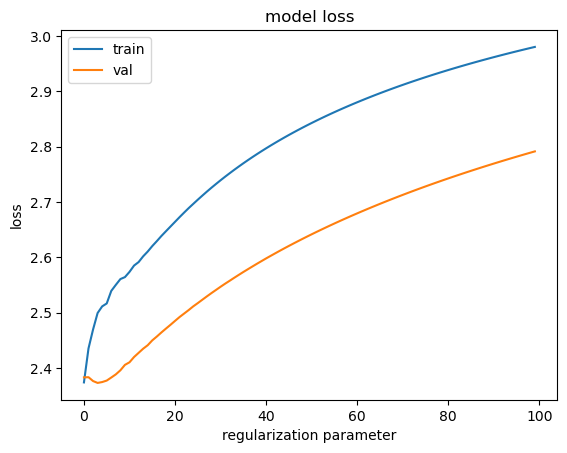

In [ ]:
plt.plot(train_losses)
plt.plot(val_losses)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('regularization parameter')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

As we increase the regularization strength, we see that both the losses are increasing and the training loss is increasing over validation loss, it means that the model is underfitting. Lets choose the regularization parameter as 0 and evaluate the test set

In [ ]:
model, train_loss = train(x_train, y_train, 100, 10, 0)

In [ ]:
train_loss

2.3800032138824463

In [ ]:
evaluate_loss(model, x_valid, y_valid)

2.3897788524627686

In [ ]:
evaluate_loss(model, x_test, y_test)

2.407710075378418

## E04
 > We saw that our 1-hot vectors merely select a row of W, so producing these vectors explicitly feels wasteful. Can you delete our use of F.one_hot in favor of simply indexing into rows of W?

In [ ]:
xs.shape

torch.Size([196113, 2])

In [ ]:
xenc_num

196113

In [ ]:
x_train, y_train = xs[train_idx], ys[train_idx]
x_valid, y_valid = xs[valid_idx], ys[valid_idx]
x_test, y_test = xs[test_idx], ys[test_idx]

In [ ]:
def train(X, y, epochs, lr, regularization_param, print_at_every_epoch = False, print_at_last=False):
    assert X.shape[-1] == 2
    num = X.shape[0]
    W = torch.randn((54, 27), requires_grad=True, generator=g)
    for i in range(epochs):
        
        #indexing
        W1 = W[:27]
        W2 = W[27:]
        
        logits = W1[X[:, 0]] + W2[X[:, 1]]
        
        counts = logits.exp()
        prob = counts/counts.sum(1, keepdims=True)
        loss = -prob[torch.arange(num), y].log().mean()
        
        # regularization
        regularization_loss = regularization_param * (W **2).mean()
        loss += regularization_loss
        
        if print_at_every_epoch: print(f'Epoch {i} Loss {loss}')
        
        W.grad = None
        loss.backward()
        W.data += -lr * W.grad 
        
    if print_at_last: print(f'Loss {loss}')
    return W, loss

In [ ]:
model, train_loss = train(x_train, y_train, 100, 10, 0)

In [ ]:
train_loss

tensor(2.3760, grad_fn=<AddBackward0>)

In [ ]:
def evaluate_loss(model, x, y):
    W1 = model[:27]
    W2 = model[27:]
    
    logits = W1[x[:, 0]] + W2[x[:, 1]]
    
    counts = logits.exp()
    prob = counts/counts.sum(1, keepdims=True)
    return -prob[torch.arange(x.shape[0]), y].log().mean()

In [ ]:
evaluate_loss(model, x_valid, y_valid)

tensor(2.3836, grad_fn=<NegBackward0>)

In [ ]:
evaluate_loss(model, x_test, y_test)

tensor(2.4045, grad_fn=<NegBackward0>)

## E05
> Look up and use F.cross_entropy instead. You should achieve the same result. Can you think of why we'd prefer to use F.cross_entropy instead?

In [ ]:
x_train, y_train = xenc_flattened[train_idx], ys[train_idx]
x_valid, y_valid = xenc_flattened[valid_idx], ys[valid_idx]
x_test, y_test = xenc_flattened[test_idx], ys[test_idx]

In [ ]:
def train(X, y, epochs, lr, print_at_every_epoch = False, print_at_last=False):
    num = X.shape[0]
    W = torch.randn((54, 27), requires_grad=True, generator=g)
    for i in range(epochs):
        logits = X @ W
        loss = F.cross_entropy(logits, y)
        
        if print_at_every_epoch: print(f'Epoch {i} Loss {loss}')
        
        W.grad = None
        loss.backward()
        W.data += -lr * W.grad 
        
    if print_at_last: print(f'Loss {loss}')
    return W, loss

In [ ]:
def evaluate_loss(model, x, y):
    logits = x @ model
    counts = logits.exp()
    pred = counts/counts.sum(1, keepdims=True)
    return - pred[torch.arange(x.shape[0]), y].log().mean().item()

In [ ]:
model, loss = train(x_train, y_train, 100, 10, 0)

In [ ]:
loss

tensor(2.3776, grad_fn=<NllLossBackward0>)

In [ ]:
evaluate_loss(model, x_valid, y_valid)

2.387678861618042

In [ ]:
evaluate_loss(model, x_test, y_test)

2.4051289558410645

Using `F.cross_entropy`, we dont have to compute the counts and probabilities ourselves instead we just have to pass the logits and labels to the function, also we can pass the weight given to each class and label smoothing

## E06
> meta-exercise! Think of a fun/interesting exercise and complete it.

Lets introduce bias, activation function and another layer of weight in the neural network 

In [ ]:
relu = torch.nn.ReLU() # activation

In [ ]:
def train(X, y, epochs, lr, print_at_every_epoch = False, print_at_last=False):
    num = X.shape[0]
    W1 = torch.randn((54, 50), requires_grad=True, generator=g)
    W2 = torch.randn((50, 27), requires_grad=True, generator=g)
    b = torch.zeros(50, requires_grad=True)
    
    for i in range(epochs):
        
        #first layer
        output = relu(X @ W1 + b)
        
        # second layer
        logits = output @ W2
        loss = F.cross_entropy(logits, y)
        
        if print_at_every_epoch: print(f'Epoch {i} Loss {loss}')
        
        W1.grad = None
        W2.grad = None
        b.grad = None
        
        loss.backward()
        W1.data += -lr * W1.grad 
        W2.data += -lr * W2.grad 
        b.data += -lr * b.grad
        
    if print_at_last: print(f'Loss {loss}')
    return W1, W2, b, loss

In [ ]:
params1, params2, bias,  loss = train(x_train, y_train, 100, 5, print_at_every_epoch = True, print_at_last = True)

Epoch 0 Loss 14.541219711303711
Epoch 1 Loss 6.2091875076293945
Epoch 2 Loss 4.395009994506836
Epoch 3 Loss 3.53914475440979
Epoch 4 Loss 3.2722010612487793
Epoch 5 Loss 3.154813766479492
Epoch 6 Loss 3.0808494091033936
Epoch 7 Loss 3.0231924057006836
Epoch 8 Loss 2.9723856449127197
Epoch 9 Loss 2.929724931716919
Epoch 10 Loss 2.8861398696899414
Epoch 11 Loss 2.8448402881622314
Epoch 12 Loss 2.8097846508026123
Epoch 13 Loss 2.7789549827575684
Epoch 14 Loss 2.7526140213012695
Epoch 15 Loss 2.7295141220092773
Epoch 16 Loss 2.709247350692749
Epoch 17 Loss 2.691128730773926
Epoch 18 Loss 2.6747939586639404
Epoch 19 Loss 2.6597096920013428
Epoch 20 Loss 2.6458194255828857
Epoch 21 Loss 2.6330149173736572
Epoch 22 Loss 2.621168851852417
Epoch 23 Loss 2.6100637912750244
Epoch 24 Loss 2.5997819900512695
Epoch 25 Loss 2.589761972427368
Epoch 26 Loss 2.5802347660064697
Epoch 27 Loss 2.5712060928344727
Epoch 28 Loss 2.5626959800720215
Epoch 29 Loss 2.553861379623413
Epoch 30 Loss 2.54574871063232

In [ ]:
def evaluate_loss(X, y, W1, W2, b):
    #first layer
    output = relu(X @ W1 + b)
        
    # second layer
    logits = output @ W2
    loss = F.cross_entropy(logits, y)
    return loss

In [ ]:
evaluate_loss(x_valid, y_valid, params1, params2, bias)

tensor(2.3825, grad_fn=<NllLossBackward0>)

In [ ]:
evaluate_loss(x_test, y_test, params1, params2, bias)

tensor(2.3918, grad_fn=<NllLossBackward0>)